<a href="https://colab.research.google.com/github/andreafought/FINAL-PROJECT/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Benford's Law and Image Tampering**

Import Libraries

In [114]:
from google.colab import files
import math
from PIL import Image
import numpy as np
import pandas as pd
import cv2 as cv2
from google.colab.patches import cv2_imshow    
from skimage import io
import glob
from tqdm import tqdm
from skimage import data, io, filters
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn import under_sampling, over_sampling 
from imblearn.over_sampling import SMOTE
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier

Image Libraries

In [147]:
camera = data.camera()

Upload Images

In [2]:
IMG1 = files.upload()

Saving IMG1.jpeg to IMG1.jpeg


In [169]:
#Import image
IMG1 = cv2.imread("IMG1.jpeg")
#Resize image
resize = cv2.resize(IMG1,(500, 500))
#Normalize image
norm = cv2.normalize(resize,np.zeros(resize.shape), 0, 255, cv2.NORM_MINMAX)
#Transform image into grey and into float
grey = cv2.cvtColor(norm, cv2.COLOR_BGR2GRAY)
img = np.float32(grey)/255.0
#Get DCT
dct = cv2.dct(img)

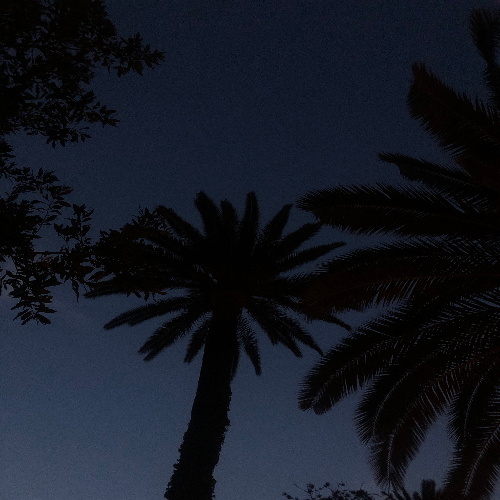

In [170]:
cv2_imshow(resize)

In [161]:
col = dct.reshape(dct.shape[0]*dct.shape[1],).tolist()
len(col)

12192768

In [142]:
def firstDigit(number):
    digits = (int)(math.log10(number)) 
    number = (int)(number / pow(10, digits)) 

In [159]:
dict_freq = {}
for digit in range(1,10):
    dict_freq[str(digit)] = 0

for value in col:
    if (type(value) is int or type(value) is float) and value>0:
      f_digit = firstDigit(value*1000000000000000000000000)
      dict_freq[str(f_digit)]+=1

KeyError: ignored

In [137]:
frequency = {}
for digit in range(1,10):
    dict_freq[str(digit)] = 0

for value in col:
    if (type(value) is int or type(value) is float) and value>0:
        f_digit = firstDigit(value*1000000000000000000000000)
        frequency[str(f_digit)]+=1

KeyError: ignored

In [123]:
frequency

{'1': 3548217,
 '2': 2221849,
 '3': 1605889,
 '4': 1225816,
 '5': 973448,
 '6': 804996,
 '7': 684803,
 '8': 596462,
 '9': 531288}

TypeError: ignored

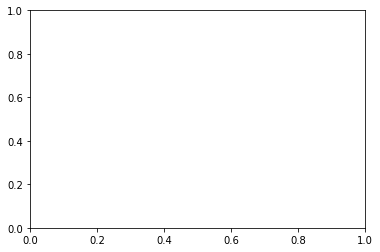

In [97]:
def firstDigit(number):
    digits = (int)(math.log10(number)) 
    number = (int)(number / pow(10, digits)) 
    return number
def graph(image_name,flag):
    
    img = cv2.imread(image_name,0)
    norm_img = np.zeros((800,800))
    final_img = cv2.normalize(img,  norm_img, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite('city_normalized.jpg', final_img)
    img = cv2.imread('./city_normalized.jpg',0)
    imf = np.float32(img)/255.0
    dst = cv2.dct(imf)
    img = np.uint8(dst)*255.0
    
    col = dst.reshape(dst.shape[0]*dst.shape[1],).tolist()
    length = len(col)
    
    
    dict_freq = {}
    for digit in range(1,10):
        dict_freq[str(digit)] = 0

    for value in col:
        if (type(value) is int or type(value) is float) and value>0:
    #         print(value)
            f_digit = firstDigit(value*1000000000000000000000000)
            dict_freq[str(f_digit)]+=1

    benford_dict = {}
    for digit in range(1,10):
        benford_dict[str(digit)] = math.log10(1+1/digit)
    freq_benf = np.array(list(benford_dict.values()))
    total_entries = 0
    
    for i in list(dict_freq.values()):
        total_entries+=i
    digits = list(dict_freq.keys())
    
    digits = list(dict_freq.keys())
    frequency = list(dict_freq.values())

    benford_freq = freq_benf * total_entries

    plt.bar(range(len(dict_freq)),frequency,tick_label=digits,color = 'silver')
    if flag==0:
        plt.plot(digits,frequency,label="Original Image Analysis",color='black',linestyle='dashed',linewidth=3,marker='o')
    else:
        plt.plot(digits,frequency,label="Modified Image Analysis",color='black',linestyle='dashed',linewidth=3,marker='o')
    plt.plot(digits,benford_freq,label="Actual Benford's Analysis",color='blue',linestyle='dashed',linewidth=3,marker='*')
    plt.xlabel('Digits')
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.savefig('result.png', dpi=300, bbox_inches='tight')
    plt.show()

In [56]:
flat_dct = [item for sublist in dct for item in sublist]

In [12]:
#flat_dct = abs(flat_dct)

In [ ]:
firstdigits(flat_dct)

In [36]:
imageravel = IMG1.ravel()
imageravel

array([ 0,  1,  2, ..., 63, 51, 47], dtype=uint8)

In [19]:
len(imageravel)

12192768

In [ ]:
plt.hist(flat_dct,256,[0,256]); plt.show()

Benford's Law

In [8]:
Benford = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

Text(0.5, 1.0, 'Benford law distribution of first digits')

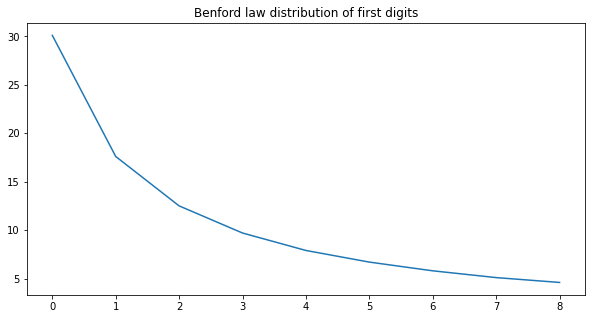

In [32]:
plt.figure(figsize=(10,5))
plt.plot(Benford)
plt.title('Benford law distribution of first digits')

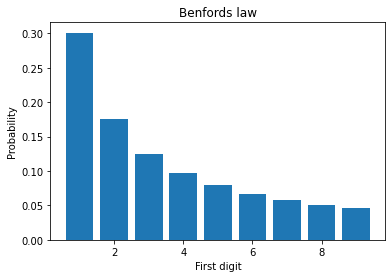

In [31]:
x = np.arange(1, 10)
benford = np.log10(1 + 1 / x)
plt.bar(x, benford)
plt.title('Benfords law')
plt.xlabel('First digit')
plt.ylabel('Probability')
plt.show()
plt.close()

In [40]:
first_digit = {}
second_digit = {}

for num in dst:
    try:
        first_digit[num[0]] += 1
    except KeyError:
        first_digit[num[0]] = 1
    
    try:
        try:
            second = num[1]
        except IndexError:
            continue
        
        second_digit[num[1]] += 1
    except KeyError:
        second_digit[num[1]] = 1

IndexError: ignored

Transform Image to DCT coefficients and collect 1st digits

In [29]:
def compute_first_digits(IMG1, normalise=False, debug_dct=False):
    if isinstance(IMG1, str):
        IMG1 = cv2.imread(IMG1, cv2.IMREAD_GRAYSCALE)
        
    if len(IMG1.shape) == 3 :
        IMG1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if normalise:
        norm = cv2.normalize(img, np.zeros(IMG1.shape), 0, 255, cv2.NORM_MINMAX)
        
    dct = cv2.dct(np.float32(IMG1) / 255.0)
    dct = np.abs(dct)  # Take abs values
    if debug_dct:
        print(dct)

    min_val = dct.min()
    if min_val < 1:
        dct = np.power(10, -np.floor(np.log10(min_val)) + 1) * dct  # Scale all up to remove leading 0.00s
    
    if not (dct >= 1.0).all():
        raise ValueError("Error")
    
    digits = np.log10(dct).astype(int).astype('float32')
    first_digits = dct / np.power(10, digits)
    first_digits[(first_digits < 1.0) & (first_digits > 0.9)] = 1  # Handle edge case.
    first_digits = first_digits.astype(int)
    
    if not (first_digits >= 1).all() and (first_digits <= 9).all():
        raise ValueError("Error")

    return first_digits


def compute_first_digits_counts(IMG1, normalise=False):
    first_digits = compute_first_digits(IMG1, normalise=normalise)
    unq, counts = np.unique(first_digits, return_counts=True)
    return unq, counts


# Small test
rnd = np.random.uniform(size=(4, 4)) * 255
compute_first_digits(rnd.astype('uint8'), debug_dct=True)

[[1.8852941  0.0509738  0.19705878 0.10494639]
 [0.19649936 0.35391515 0.0144545  0.01744357]
 [0.4284314  0.16897151 0.54019606 0.01596439]
 [0.12341285 0.54685533 0.02402713 0.17156218]]


array([[1, 5, 1, 1],
       [1, 3, 1, 1],
       [4, 1, 5, 1],
       [1, 5, 2, 1]])

In [20]:
def prototype_image(image):
    IMG1 = cv2.cvtColor(IMG1, cv2.COLOR_BGR2GRAY)
    plt.imshow(IMG1, cmap='gray')
    plt.show()

    first_digits = compute_first_digits(IMG1)
    plt.imshow(first_digits)
    plt.show()

    unq, counts = np.unique(first_digits, return_counts=True)
    tot = counts.sum()
    counts = counts / tot
    plt.plot(unq, counts, color='red', marker='x', linestyle='dashed', linewidth=2, markersize=12)
    plt.bar(unq, benford, color='blue')
    plt.show()
    plt.close()

    print(stats.chisquare(counts, benford))


In [42]:
reference = sorted(glob.glob('../input/compare-difference-bw-lepord-and-tiger/compare lepord and tiger/*/*/*.jpg'))
counts_ref = np.array([compute_first_digits_counts(x)[1] for x in tqdm.tqdm(reference)])
counts_mod = np.array([compute_first_digits_counts(tamper_image(cv2.imread(x, cv2.IMREAD_GRAYSCALE)))[1] for x in tqdm.tqdm(reference)])

counts_ref_norm = counts_ref / counts_ref.sum(axis=1)[..., np.newaxis]
counts_mod_norm = counts_mod / counts_mod.sum(axis=1)[..., np.newaxis]

AttributeError: ignored

IndexError: ignored

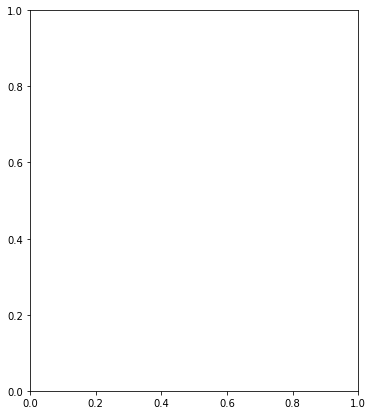

In [17]:
plt.figure(figsize=(20, 7))

plt.subplot(131)
plt.bar([num for num in rnd], [rnd[num] for num in rnd])
plt.title('Occurences of first digits')
plt.xlabel('First digit')
plt.ylabel('Occurences')

Create dataframe

Machine Learning using decision tree method